This one was inspired by an example I did this week for the class I'm teaching: I wanted to apply an RDKit reaction to a set of reactants and then draw the reactants and the products of the reaction as a normal reaction with the mapped atoms indicated. Doing that made me realize that, with a bit more code, I could produce some other useful views of a reaction.

In addition to the visualizations themselves, this post has some potentially useful details about what kind of extra information is available in the products of reactions.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdChemReactions

import rdkit
print(rdkit.__version__)

2025.09.1


The first example reaction, adapted from the SI for http://pubs.acs.org/doi/abs/10.1021/ci200379p. I frequently use this paper as a source of reaction SMARTS definitions for real reactions; left to my own devices I would just use amide bond formation all the time, and that gets pretty boring pretty quick. 

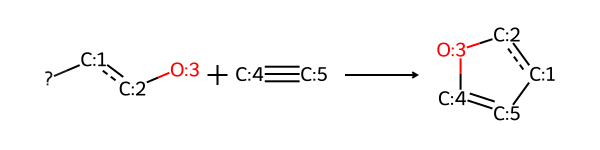

In [2]:
# adapted example from the SI for: http://pubs.acs.org/doi/abs/10.1021/ci200379p
sma = '[Br,I;$(*c1ccccc1)]-[c:1]:[c:2]-[OH1:3].[CH1:5]#[C;$(C-[#6]):4]>>[c:1]1:[c:2]-[O:3]-[C:4]=[C:5]-1'
rxn = rdChemReactions.ReactionFromSmarts(sma)
rxn

A set of reactants for the reaction:

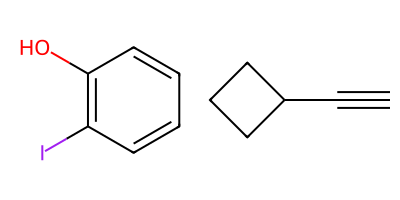

In [3]:
r1 = Chem.MolFromSmiles('c1cc(I)c(O)cc1')
r2 = Chem.MolFromSmiles('C1CCC1C#C')
Draw.MolsToGridImage([r1,r2],molsPerRow=2)

Run the reaction and show the product:

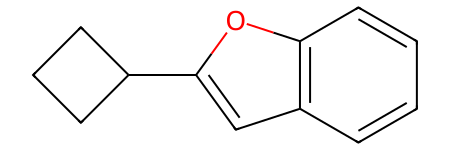

In [4]:
reactants = (r1,r2)

ps = rxn.RunReactants(reactants)
ps[0][0]

Look at the properties set on one of the atoms in the product that came from a mapped atom:

In [5]:
prod = ps[0][0]
print('mapped atom:',prod.GetAtomWithIdx(0).GetPropsAsDict(includePrivate=False))
print('unmapped atom:',prod.GetAtomWithIdx(8).GetPropsAsDict(includePrivate=False))

mapped atom: {'old_mapno': 1, 'react_atom_idx': 2, 'react_idx': 0}
unmapped atom: {'react_atom_idx': 6, 'react_idx': 0}


Here's what those mean:
1. `old_mapno`: the atom map number for the atom (obviously only present on mapped atoms)
2. `react_idx`: which reactant the atom came from
3. `react_atom_idx`: the index of the atom in its reactant

What I did for the course was set the atom map numbers on the reactants and products, combine them into a new reaction, and then display that reaction.

Start by setting the atom map numbers:

In [6]:
# since we're going to modify things, copy them first:
prod = Chem.Mol(ps[0][0])
reactants = (Chem.Mol(r1),Chem.Mol(r2))

for at in prod.GetAtoms():
    pd = at.GetPropsAsDict()
    if 'old_mapno' not in pd:
        continue
    r = reactants[pd['react_idx']]
    rat = r.GetAtomWithIdx(pd['react_atom_idx'])
    rat.SetAtomMapNum(pd['old_mapno'])
    at.SetAtomMapNum(pd['old_mapno'])

Now create the reaction and display it:

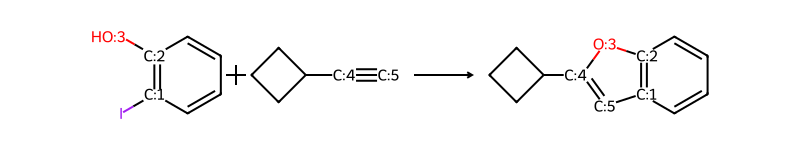

In [7]:
nrxn = rdChemReactions.ChemicalReaction()
nrxn.AddReactantTemplate(reactants[0])
nrxn.AddReactantTemplate(reactants[1])
nrxn.AddProductTemplate(prod)

IPythonConsole.molSize = 600,150
nrxn

Once the atom-mapping information is there, The reaction drawing code can also highlight the atoms based upon which reactant they came from. Unfortunately this causes the atom-mapping information to not be displayed:

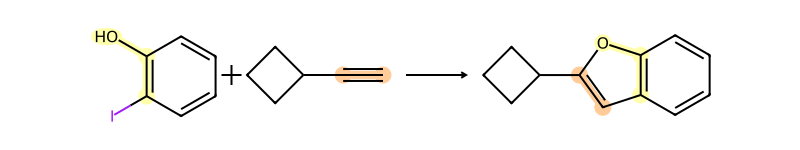

In [8]:
IPythonConsole.highlightByReactant = True
nrxn

In [9]:
IPythonConsole.highlightByReactant = False


At this point it makes sense to take what we know and write a function to draw the highlighted reaction. By working directly with a MolDraw2DCairo object instead of using the notebook integration we more easily control what's going on.

In [10]:
from IPython.display import Image
def drawHighlightedReaction(rxn, reacts, prods, 
                            includeAtomMaps=True, highlightAllAtoms=True,
                            mapAllAtoms=False,
                            highlightColors=None,
                            size=(900,200), annotationFontScale=0.74,
                            drawOptions=None):
    ''' draws a specific reaction with the reactants and products highlighted
    Returns an Image object with the drawing.    
    
    Arguments
    rxn: the reaction object (not currently used)
    reacts: a sequence of molecules. The reactants used in the reaction
    prods: a sequence of molecules. The products from the reaction
    includeAtomMaps: bool. Whether or not atom map numbers should be included in the output
    highlightAllAtoms: bool. Whether or not to highlight all reactant/product atoms in the output. 
                           If True, non-mapped atoms will be highlighted. 
                           If False, only the mapped atoms will be highlighted
    mapAllAtoms: bool. Whether or not to include atom mapping numbers on all atoms.
                           If True, non-mapped atoms will have negative atom map numbers displayed
    highlightColors: sequence of 3-tuples. Controls the colors used for highlighting the reactants.
                           The values should go from 0-1. The sequence should have (at least) len(reacts) 
                           elements.
    size: tuple. Controls the size of the output image.
    annotationFontScale: float. Controls the size of the atom map notes (if being drawn)
    drawOptions: a MolDraw2DOptions object. Used as the draw options for the rendering. 
                           Overrides annotationFontScale if provided.
    
    '''
    # make copies of all the reactants and the products since we will modify them
    reacts = [Chem.Mol(r) for r in reacts]
    prods = [Chem.Mol(p) for p in prods]
    
    # find the largest atom map number, used to initialize the negative atom map numbers
    #  when we are doing highlightAllAtoms
    negVal = 0
    if mapAllAtoms:
        for prod in prods:
            for at in prod.GetAtoms():
                if at.HasProp('old_mapno'):
                    negVal = min(negVal,-1 * at.GetIntProp('old_mapno'))
    negVal -= 1

    # loop over each of the products and set the atom map and note information
    #  in both the product atoms and corresponding reactant atoms.
    for prod in prods:
        for at in prod.GetAtoms():
            pd = at.GetPropsAsDict()
            mno = pd.get('old_mapno',negVal)
            if mno<0:
                if not highlightAllAtoms:
                    continue
                else:
                    negVal -= 1
            
            r = reacts[pd['react_idx']]
            rat = r.GetAtomWithIdx(pd['react_atom_idx'])
            for tat in at,rat:
                tat.SetAtomMapNum(mno)
                if includeAtomMaps and (mno>0 or mapAllAtoms):
                    tat.SetProp('atomNote',str(mno))    
    
    # create the reaction we'll actually render:
    nrxn = rdChemReactions.ChemicalReaction()
    for react in reacts:
        nrxn.AddReactantTemplate(react)
    for prod in prods:
        nrxn.AddProductTemplate(prod)

    # and draw it
    d2d = Draw.MolDraw2DCairo(size[0],size[1])
    if drawOptions is not None:
        d2d.SetDrawOptions(drawOptions)
    else:
        d2d.drawOptions().annotationFontScale=annotationFontScale
    d2d.DrawReaction(nrxn, highlightByReactant=True, highlightColorsReactants=highlightColors)
    d2d.FinishDrawing()
    return Image(d2d.GetDrawingText())

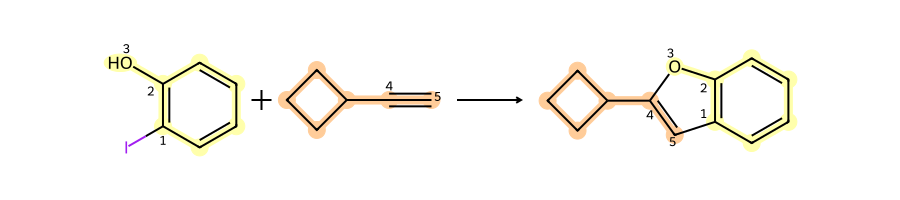

In [11]:
r1 = Chem.MolFromSmiles('c1cc(I)c(O)cc1')
r2 = Chem.MolFromSmiles('C1CCC1C#C')
reactants = (r1,r2)
ps = rxn.RunReactants(reactants)

drawHighlightedReaction(rxn,reactants,ps[0])

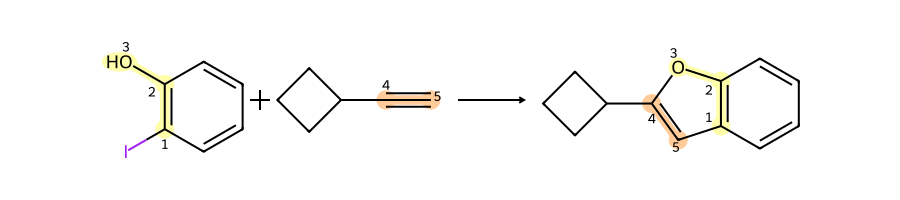

In [12]:
drawHighlightedReaction(rxn,reactants,ps[0],highlightAllAtoms=False)

Include negative atom map numbers for atoms that were not in the reaction definition;

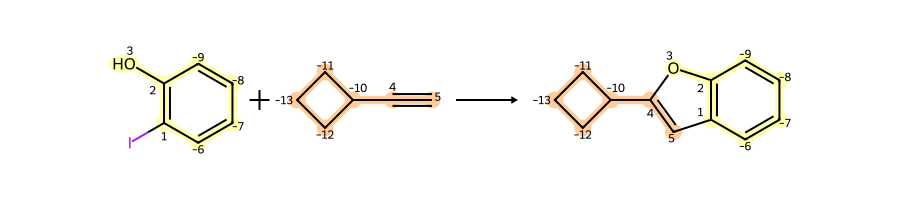

In [13]:
drawHighlightedReaction(rxn,reactants,ps[0],mapAllAtoms=True)

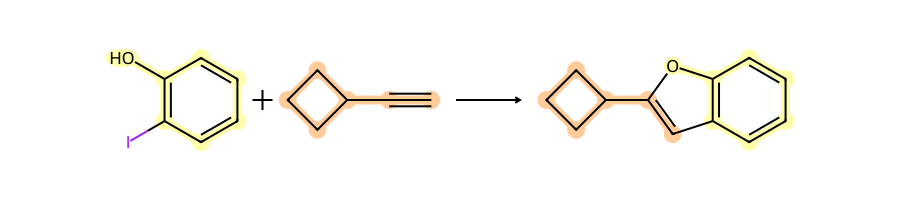

In [14]:
drawHighlightedReaction(rxn,reactants,ps[0],includeAtomMaps=False)

Change the highlighting

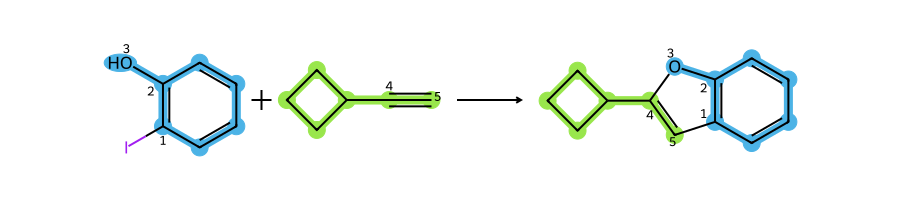

In [15]:
drawHighlightedReaction(rxn,reactants,ps[0],highlightColors=[(0.3, 0.7, 0.9), (0.6, 0.9, 0.3)])

Provide our own draw options. Here we play with dark mode:

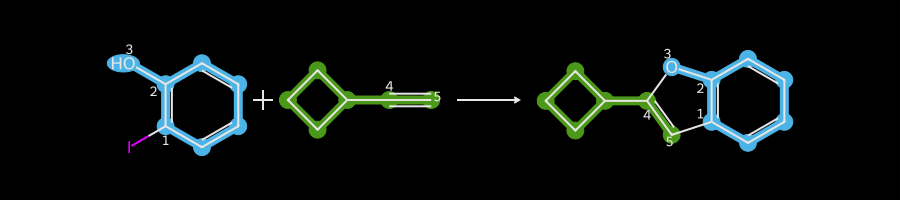

In [16]:
from rdkit.Chem import rdDepictor
for r in reactants:
    rdDepictor.Compute2DCoords(r)
dopts = Draw.MolDrawOptions()
Draw.SetDarkMode(dopts)
dopts.annotationFontScale = 0.8
drawHighlightedReaction(rxn,reactants,ps[0],drawOptions=dopts,
                       highlightColors=[(0.3, 0.7, 0.9), (0.3, 0.6, 0.1)])

Do another reaction from the same paper:

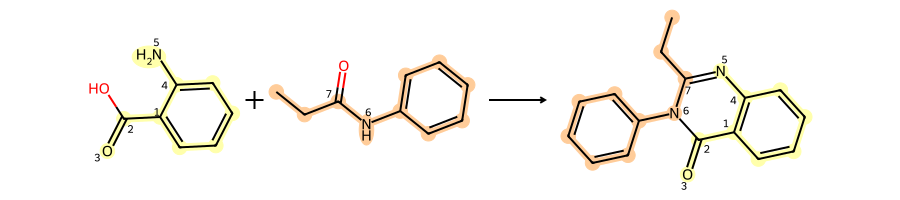

In [17]:
rxn = rdChemReactions.ReactionFromSmarts('[c:1](-[C;$(C-c1ccccc1):2](=[OD1:3])-[OH1]):[c:4](-[NH2:5]).[N;!H0;!$(N-N);!$(N-C=N);!$(N(-C=O)-C=O):6]-[C;H1,$(C-[#6]):7]=[OD1]>>[c:4]2:[c:1]-[C:2](=[O:3])-[N:6]-[C:7]=[N:5]-2')
reactants = [Chem.MolFromSmiles(x) for x in ('c1c(C(=O)O)c(N)ccc1','CCC(=O)Nc1ccccc1')]
prods = rxn.RunReactants(reactants)
drawHighlightedReaction(rxn,reactants,prods[0])